# Classification Modeling - By Hotel

---

The initial modeling results revealed challenges in accurately classifying reservations, which may stem from significant differences between the two types of hotels in the dataset and from class imbalances in the data. To address these issues, I will train and evaluate separate models for each hotel in this notebook. While this approach is more time and resource-intensive than the combined model—a factor to consider in a production environment—splitting the dataset and developing individual models will help account for the unique characteristics and reservation patterns of each hotel.

Additionally, to tackle the class imbalance inherent in the dataset, I will employ SMOTE with Tomek Links. This technique combines the Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic examples of the minority class with Tomek Links to remove overlapping instances from the majority class. By integrating this resampling method into the modeling pipeline, I aim to create a more balanced and cleaner dataset. This combined strategy is expected to enhance classification performance by leveraging hotel-specific insights and effectively addressing the class imbalance.



---

# Imports

In [49]:
import pandas as pd
import seaborn as sns
import shap

In [50]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [51]:
# from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

set_config(transform_output='pandas')

# Load Data

In [52]:
df_data = pd.read_parquet('../../data/3.2_data_with_occupancies.parquet')
df_data

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,Adults,Children,Babies,Meal,Country,...,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_DayOfWeek,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
0,342,2015,July,27,1,2,0.0,0,BB,PRT,...,21,45,21,22,44,3,41,41,0.115169,0.115169
56,149,2015,July,27,1,2,1.0,0,BB,IRL,...,21,38,28,60,32,3,41,201,0.115169,0.564607
57,149,2015,July,27,1,2,0.0,0,BB,IRL,...,21,38,28,60,32,3,41,201,0.115169,0.564607
58,145,2015,July,27,1,2,0.0,0,HB,GBR,...,21,38,28,56,36,3,41,201,0.115169,0.564607
59,110,2015,July,27,1,3,0.0,0,BB,ESP,...,21,40,26,21,71,3,41,172,0.115169,0.483146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119362,4,2017,August,35,31,2,0.0,0,SC,FRA,...,16,32,19,39,12,4,271,102,0.761236,0.286517
119366,198,2017,August,35,31,2,0.0,0,SC,GBR,...,16,33,18,59,44,4,271,154,0.761236,0.432584
119372,332,2017,August,35,31,2,0.0,0,BB,GBR,...,16,33,18,2,49,4,271,154,0.761236,0.432584
119380,109,2017,August,35,31,2,0.0,0,BB,GBR,...,16,28,23,27,13,4,271,22,0.761236,0.061798


# Split By Hotel Number

In [53]:
df_data = df_data[df_data['HotelNumber'] == 'H1']
df_data = df_data.reset_index(drop=True)
df_data

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,Adults,Children,Babies,Meal,Country,...,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_DayOfWeek,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
0,342,2015,July,27,1,2,0.0,0,BB,PRT,...,21,45,21,22,44,3,41,41,0.115169,0.115169
1,149,2015,July,27,1,2,1.0,0,BB,IRL,...,21,38,28,60,32,3,41,201,0.115169,0.564607
2,149,2015,July,27,1,2,0.0,0,BB,IRL,...,21,38,28,60,32,3,41,201,0.115169,0.564607
3,145,2015,July,27,1,2,0.0,0,HB,GBR,...,21,38,28,56,36,3,41,201,0.115169,0.564607
4,110,2015,July,27,1,3,0.0,0,BB,ESP,...,21,40,26,21,71,3,41,172,0.115169,0.483146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,70,2017,August,35,31,2,0.0,0,BB,ESP,...,16,32,19,54,7,4,271,102,0.761236,0.286517
40056,108,2017,August,35,31,2,0.0,0,HB,GBR,...,16,28,23,26,14,4,271,22,0.761236,0.061798
40057,194,2017,August,35,31,2,1.0,0,HB,ITA,...,16,28,23,55,48,4,271,22,0.761236,0.061798
40058,17,2017,August,35,31,2,0.0,0,HB,ESP,...,16,32,19,1,60,4,271,102,0.761236,0.286517


In [54]:
df_data.columns.to_list()

['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateMonth',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'Adults',
 'Children',
 'Babies',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'ReservedRoomType',
 'AssignedRoomType',
 'BookingChanges',
 'DepositType',
 'Agent',
 'Company',
 'DaysInWaitingList',
 'CustomerType',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ReservationStatus',
 'HotelNumber',
 'ArrivalDate',
 'DepartureDate',
 'Length of Stay',
 'BookingDate',
 'ArrivalDate_DaysBeforeHoliday',
 'ArrivalDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'DepartureDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'BookingDate_DaysAfterHoliday',
 'ArrivalDate_DayOfWeek',
 'occupancy_at_arrival',
 'occupancy_at_departure',
 'occupancy_pct_at_arrival',
 'occupancy_pct_at_departure']

In [55]:
selected_features = ['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateMonth',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'Adults',
 'Children',
 'Babies',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'ReservedRoomType',
 'AssignedRoomType',
 'BookingChanges',
 'DepositType',
 'Agent',
 'Company',
 'DaysInWaitingList',
 'CustomerType',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ReservationStatus',
 'HotelNumber',
 'ArrivalDate',
 'DepartureDate',
 'Length of Stay',
 'BookingDate',
 'ArrivalDate_DaysBeforeHoliday',
 'ArrivalDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'DepartureDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'BookingDate_DaysAfterHoliday',
 'ArrivalDate_DayOfWeek',
 'occupancy_at_arrival',
 'occupancy_at_departure',
 'occupancy_pct_at_arrival',
 'occupancy_pct_at_departure']

In [56]:
df_data = df_data[selected_features]
df_data

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,Adults,Children,Babies,Meal,Country,...,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_DayOfWeek,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
0,342,2015,July,27,1,2,0.0,0,BB,PRT,...,21,45,21,22,44,3,41,41,0.115169,0.115169
1,149,2015,July,27,1,2,1.0,0,BB,IRL,...,21,38,28,60,32,3,41,201,0.115169,0.564607
2,149,2015,July,27,1,2,0.0,0,BB,IRL,...,21,38,28,60,32,3,41,201,0.115169,0.564607
3,145,2015,July,27,1,2,0.0,0,HB,GBR,...,21,38,28,56,36,3,41,201,0.115169,0.564607
4,110,2015,July,27,1,3,0.0,0,BB,ESP,...,21,40,26,21,71,3,41,172,0.115169,0.483146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,70,2017,August,35,31,2,0.0,0,BB,ESP,...,16,32,19,54,7,4,271,102,0.761236,0.286517
40056,108,2017,August,35,31,2,0.0,0,HB,GBR,...,16,28,23,26,14,4,271,22,0.761236,0.061798
40057,194,2017,August,35,31,2,1.0,0,HB,ITA,...,16,28,23,55,48,4,271,22,0.761236,0.061798
40058,17,2017,August,35,31,2,0.0,0,HB,ESP,...,16,32,19,1,60,4,271,102,0.761236,0.286517


# Train/Test Split

In [57]:
target_feature = 'ReservationStatus'

X = df_data.loc[:, selected_features].drop(columns=target_feature)
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify=y)

In [58]:
y_train.value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.72
Canceled     0.28
Name: proportion, dtype: float64

In [59]:
y_test.value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.72
Canceled     0.28
Name: proportion, dtype: float64

# Random Forest Classifer Model Without SMOTE/Tuning

In [60]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              min_frequency=5,
                              max_categories=25))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Build the full pipeline without SMOTE resampling
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced_subsample'))
])

# Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## Model Results

              precision    recall  f1-score   support

    Canceled       0.87      0.80      0.83     11122
   Check-Out       0.92      0.95      0.94     28938

    accuracy                           0.91     40060
   macro avg       0.90      0.88      0.89     40060
weighted avg       0.91      0.91      0.91     40060



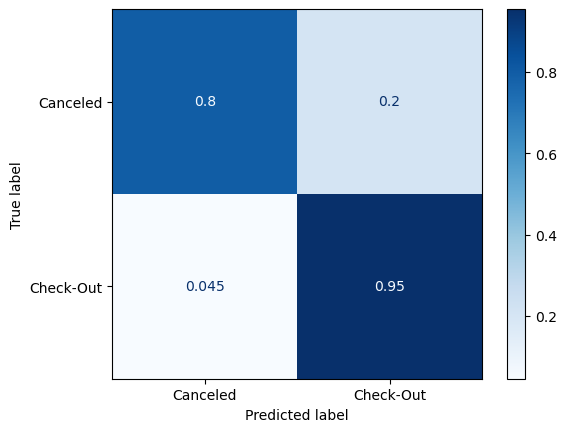

In [61]:
y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

print(classification_report(y, y_pred))

ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

### Tree Depths

In [62]:
# Access the fitted model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['LeadTime', 'ArrivalDateWeekNumber', 'Adults', 'Children', 'Babies',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList',
       'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialReque...
                                                                                 sparse_output=False))]),
                                                  Index(['ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth', 'Meal',
       'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType',
       'AssignedRoomType', 'DepositType', 'Agent', 'Company', 'CustomerType',
       'HotelNumber'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        random_state=42))])

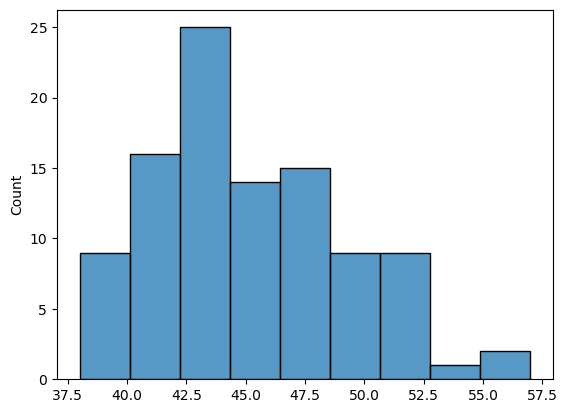

In [63]:
# Get the depths of the trees in the fitted model
depths = [tree.get_depth() for tree in model_pipeline[-1].estimators_]

# Plot the histogram of tree depths
sns.histplot(depths);

# Performing SMOTE to Handle Class Imbalance

---

1. Use preprocessor outside of pipeline to OHE categoricals
2. Check results
3. Create boolean index to identify which columns to treat as categoricals
4. Instantiate a SMOTENC object
5. Reset `set_config` setting to "default" due to compatibility issues
6. Use `.fit_resample` method to perform SMOTENC
7. Reset `set_config` back to "pandas" and convert output data back to DataFrames
8. Confirm OHE'ed categoricals consist only of numeric features again.

---

In [64]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [65]:
X_train_transformed.head()

,num__LeadTime,num__ArrivalDateWeekNumber,num__Adults,num__Children,num__Babies,num__IsRepeatedGuest,num__PreviousCancellations,num__PreviousBookingsNotCanceled,num__BookingChanges,num__DaysInWaitingList,...,cat__Company_ 343,cat__Company_ 405,cat__Company_ 498,cat__Company_ NULL,cat__Company_infrequent_sklearn,cat__CustomerType_Contract,cat__CustomerType_Group,cat__CustomerType_Transient,cat__CustomerType_Transient-Party,cat__HotelNumber_H1
6634,122.0,47.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
33515,156.0,19.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
36322,178.0,26.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
36439,148.0,26.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1814,19.0,33.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [66]:
cat_features = [col.startswith('cat_') for col in X_train_transformed.columns]
cat_features

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 T

In [67]:
## Reset output settings to default for SMOTE
set_config(transform_output='default')

## Perform SMOTE resampling
snc = SMOTENC(categorical_features=cat_features, random_state = 42)
X_train_smote, y_train_smote = snc.fit_resample(X_train_transformed, y_train)

In [68]:
## Reset output settings to pandas
set_config(transform_output='pandas')

X_train_smote = pd.DataFrame(X_train_smote, columns=X_train_transformed.columns)
y_train_smote = pd.Series(y_train_smote)

In [69]:
X_train_smote.nunique()

num__LeadTime                        9464
num__ArrivalDateWeekNumber           4780
num__Adults                          2174
num__Children                        1845
num__Babies                           214
                                     ... 
cat__CustomerType_Contract              2
cat__CustomerType_Group                 2
cat__CustomerType_Transient             2
cat__CustomerType_Transient-Party       2
cat__HotelNumber_H1                     1
Length: 181, dtype: int64

# Random Forest Classifer Model Post-SMOTENC

In [70]:
smotenc_model = model_pipeline[-1].fit(X_train_smote, y_train_smote)

              precision    recall  f1-score   support

    Canceled       0.84      0.82      0.83      2781
   Check-Out       0.93      0.94      0.94      7234

    accuracy                           0.91     10015
   macro avg       0.89      0.88      0.88     10015
weighted avg       0.91      0.91      0.91     10015



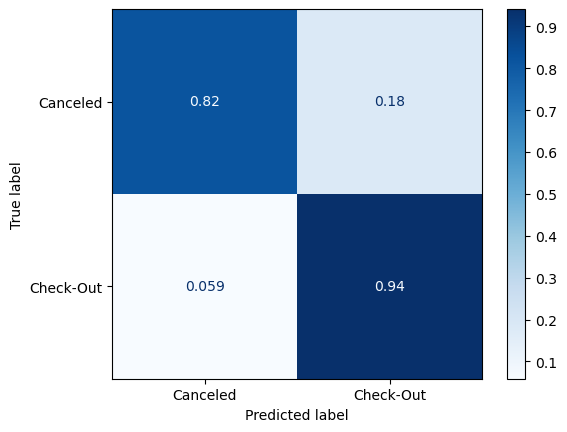

In [71]:
y_pred = smotenc_model.predict(X_test_transformed)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

# Reviewing Results with SHAP

In [73]:
# ## Use only if using model pipeline without SMOTENC
# X_train_xf = model_pipeline.named_steps.preprocessor.fit_transform(X_train)
# X_test_xf = model_pipeline.named_steps.preprocessor.transform(X_test)

# X_shap_train = shap.sample(X_train_xf, 500)
# y_shap_train = y_train.loc[X_shap_train.index]

# X_shap_test = shap.sample(X_test_xf, 500)
# y_shap_test = y_test.loc[X_shap_test.index]

# explainer = shap.Explainer(model_pipeline.named_steps.classifier, X_shap_train)
# # shap_values_train = explainer(X_shap_train)
# shap_values_test = explainer(X_shap_test)

In [77]:
## Use only if using SMOTENC data and associated model

X_train_xf = X_train_smote
X_test_xf = X_test_transformed

X_shap_train = shap.sample(X_train_xf, 500)
y_shap_train = y_train_smote.loc[X_shap_train.index]

X_shap_test = shap.sample(X_test_xf, 500)
y_shap_test = y_test.loc[X_shap_test.index]

explainer = shap.Explainer(smotenc_model, X_shap_train)
# shap_values_train = explainer(X_shap_train)
shap_values_test = explainer(X_shap_test)

 99%|===================| 991/1000 [01:05<00:00]        

In [78]:
# print(shap_values_train.shape)
print(shap_values_test.shape)

(500, 181, 2)


### Summary Plot

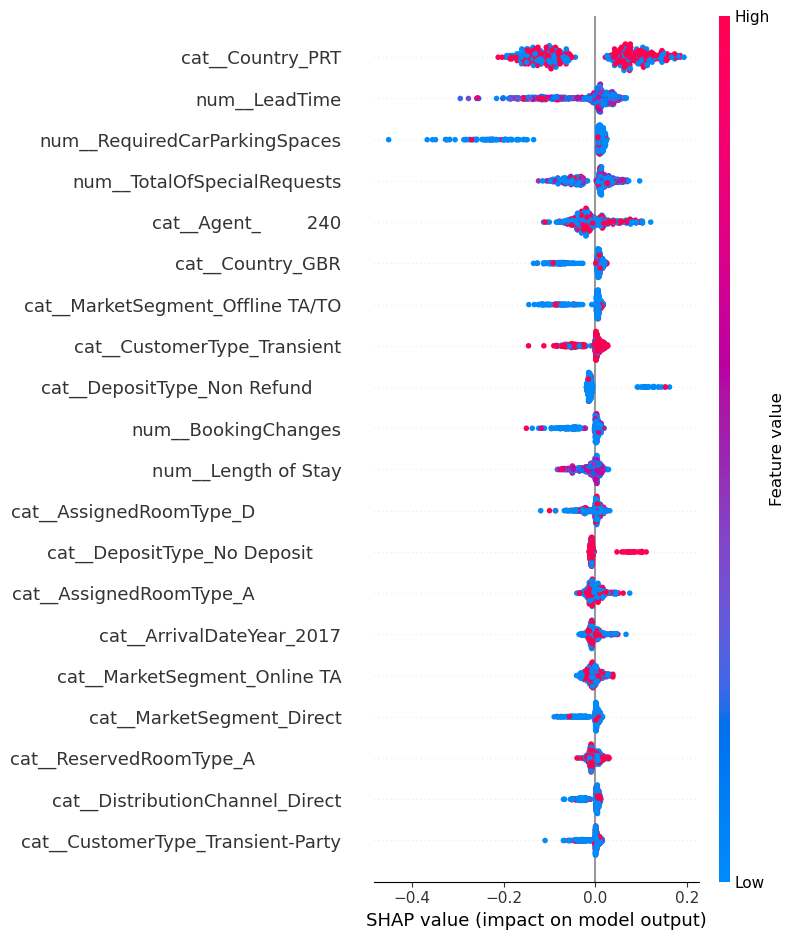

In [79]:
shap.summary_plot(shap_values_test[:, :, 0], X_shap_train)

In [27]:
# df_data.groupby(['Country'])[['ReservationStatus']].value_counts(normalize=True).loc['PRT']

### Force Plot

In [28]:
# For multiple predictions
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

# `HistGradientBoostingClassifier` Approach

In [40]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=200))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    # ('yeojohnson', PowerTransformer(method='yeo-johnson')),
    # ('scaler', StandardScaler())
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Create the RandomForestClassifier model
classifier = HistGradientBoostingClassifier(class_weight='balanced',
                                            scoring = 'f1_weighted')

hgbr_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):
    
    # Fit the model and generate predictions
    hgbr_model_pipeline.fit(X_train, y_train)

hgbr_y_pred = hgbr_model_pipeline.predict(X_test)

# Evaluate performance metrics
hgbr_score_training = hgbr_model_pipeline.score(X_train, y_train)
hgbr_score_testing = hgbr_model_pipeline.score(X_test, y_test)

In [ ]:
classification_results(model_pipeline = hgbr_model_pipeline,
                       X_train = X_train,
                       X_test = X_test,
                       y_train = y_train,
                       y_test = y_test);

In [ ]:
# Calculate permutation importances
result = permutation_importance(hgbr_model_pipeline,X_test, y_test,n_jobs=-1)

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

## SHAP - HGBR

In [ ]:
X_train_xf = hgbr_model_pipeline.named_steps.preprocessor.fit_transform(X_train)
X_train_xf

In [ ]:
X_shap = shap.sample(X_train_xf, 10000)
X_shap

In [ ]:
y_shap = y_train.loc[X_shap.index]
y_shap

In [ ]:
hgbr_model_pipeline

In [ ]:
# explainer = shap.Explainer(hgbr_model_pipeline.named_steps.classifier, X_shap)
explainer = shap.Explainer(hgbr_model_pipeline.named_steps['classifier'])
shap_values = explainer(X_shap)
shap_values.shape

## Summary Plot

In [ ]:
shap.summary_plot(shap_values, X_shap)

# Results and Recommendations

Based on the SHAP results, **we can infer characteristics of guests who are less likely to cancel their reservations.** These characteristics can help define the target market for the hotels to minimize cancellations. Here's an example of an ideal target market:

## Target Market for Minimizing Hotel Reservation Cancellations

1. **Length of Stay**:
   - **Profile**: Guests who book longer stays.
   - **Reason**: Longer stays are associated with a lower likelihood of cancellation.

2. **Days Since Booking**:
   - **Profile**: Guests who book well in advance.
   - **Reason**: A higher number of days since booking indicates a lower likelihood of cancellation.

3. **Deposit Type**:
   - **Profile**: Guests willing to make non-refundable deposits.
   - **Reason**: Non-refundable deposits significantly reduce the likelihood of cancellation.

4. **Country of Origin**:
   - **Profile**: Guests from specific countries like Portugal (PRT).
   - **Reason**: Guests from certain countries show a lower likelihood of cancellation.

5. **Market Segment**:
   - **Profile**: Guests booking through Online Travel Agents (OTA).
   - **Reason**: Bookings through OTAs are less likely to be canceled.


## Example Target Market Persona:

### **1. Business Traveler:**
- **Length of Stay**: 4-7 days
- **Booking Time**: At least 2-3 months in advance
- **Deposit**: Non-refundable
- **Country**: Portugal (PRT) or other identified low-cancellation countries
- **Booking Channel**: Online Travel Agent (OTA)
- **Travel Period**: Not immediately before or after major holidays
- **Customer Type**: Individual transient
- **Booking Changes**: Minimal to no changes post-booking

### **2. Family Vacationers:**
- **Length of Stay**: 5-10 days
- **Booking Time**: 3-6 months in advance
- **Deposit**: Non-refundable
- **Country**: Identified low-cancellation countries (e.g., Portugal)
- **Booking Channel**: OTA or direct website booking
- **Travel Period**: Booking dates that avoid peak holiday disruptions
- **Customer Type**: Transient, not part of group deals
- **Booking Changes**: Stable itinerary with few changes

## Marketing Strategies:

1. **Early Bird Promotions**: Encourage early bookings with attractive discounts for longer stays.
2. **Non-Refundable Deposit Discounts**: Offer special rates for bookings with non-refundable deposits.
3. **Country-Specific Campaigns**: Tailor marketing efforts towards countries with lower cancellation rates.
4. **OTA Partnerships**: Strengthen relationships with online travel agents to attract more reliable bookings.
5. **Holiday Package Adjustments**: Optimize packages and promotions to avoid booking peaks right before or after holidays.
6. **Loyalty Programs for Transient Guests**: Create loyalty programs that cater to individual transient travelers with stable travel plans.
7. **Agent Performance Monitoring**: Monitor and incentivize agents with better non-cancellation records to maintain quality bookings.

By focusing on these customer profiles and implementing targeted marketing strategies, the hotel can effectively reduce reservation cancellations and optimize their booking stability.

In [35]:
raise Exception('Appendices below - run manually!')

Exception: Appendices below - run manually!

# Appendices

## Testing - Using Only Numeric Features w/ SMOTETomek

In [ ]:
# Combine transformers into a single ColumnTransformer
preprocessor_num = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats)
])

In [ ]:
X_train_numeric = preprocessor_num.fit_transform(X_train)
X_test_numeric = preprocessor_num.transform(X_test)

In [ ]:
X_train_numeric

,num__LeadTime,num__ArrivalDateWeekNumber,num__Adults,num__Children,num__Babies,num__IsRepeatedGuest,num__PreviousCancellations,num__PreviousBookingsNotCanceled,num__BookingChanges,num__DaysInWaitingList,...,num__ArrivalDate_DaysAfterHoliday,num__DepartureDate_DaysBeforeHoliday,num__DepartureDate_DaysAfterHoliday,num__BookingDate_DaysBeforeHoliday,num__BookingDate_DaysAfterHoliday,num__ArrivalDate_DayOfWeek,num__occupancy_at_arrival,num__occupancy_at_departure,num__occupancy_pct_at_arrival,num__occupancy_pct_at_departure
18151,122.0,47.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,97.0,16.0,99.0,25.0,41.0,5.0,188.0,119.0,0.528090,0.334270
98705,156.0,19.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,26.0,14.0,5.0,2.0,1.0,248.0,235.0,0.696629,0.660112
108346,178.0,26.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,45.0,16.0,2.0,5.0,1.0,308.0,309.0,0.865169,0.867978
108968,148.0,26.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,45.0,16.0,71.0,32.0,5.0,300.0,309.0,0.842697,0.867978
3902,19.0,33.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,61.0,2.0,64.0,24.0,42.0,1.0,243.0,262.0,0.682584,0.735955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75391,130.0,49.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,...,2.0,15.0,2.0,20.0,46.0,6.0,185.0,153.0,0.519663,0.429775
60486,157.0,38.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.0,20.0,31.0,18.0,11.0,7.0,244.0,215.0,0.685393,0.603933
56012,45.0,34.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,65.0,50.0,1.0,46.0,20.0,7.0,293.0,294.0,0.823034,0.825843
70289,0.0,45.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,26.0,30.0,0.0,1.0,26.0,1.0,258.0,261.0,0.724719,0.733146


In [ ]:
## Set output settings to default arrays and apply SMOTETomek to balance the dataset
set_config(transform_output='default')

smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train_numeric, y_train)

In [ ]:
## Reset output settings to pandas and convert resampled data to DataFrames
set_config(transform_output='pandas')

X_train_num_STL = pd.DataFrame(X_resampled, columns=X_train_numeric.columns)
y_train_num_STL = pd.Series(y_resampled)

In [ ]:
# Initialize and train the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_classifier.fit(X_train_num_STL, y_train_num_STL)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
X_train_num_STL

,num__LeadTime,num__ArrivalDateWeekNumber,num__Adults,num__Children,num__Babies,num__IsRepeatedGuest,num__PreviousCancellations,num__PreviousBookingsNotCanceled,num__BookingChanges,num__DaysInWaitingList,...,num__ArrivalDate_DaysAfterHoliday,num__DepartureDate_DaysBeforeHoliday,num__DepartureDate_DaysAfterHoliday,num__BookingDate_DaysBeforeHoliday,num__BookingDate_DaysAfterHoliday,num__ArrivalDate_DayOfWeek,num__occupancy_at_arrival,num__occupancy_at_departure,num__occupancy_pct_at_arrival,num__occupancy_pct_at_departure
0,122.000000,47.0,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,97.000000,16.000000,99.000000,25.000000,41.000000,5.000000,188.000000,119.000000,0.528090,0.334270
1,156.000000,19.0,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,7.000000,26.000000,14.000000,5.000000,2.000000,1.000000,248.000000,235.000000,0.696629,0.660112
2,178.000000,26.0,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,11.000000,45.000000,16.000000,2.000000,5.000000,1.000000,308.000000,309.000000,0.865169,0.867978
3,148.000000,26.0,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,15.000000,45.000000,16.000000,71.000000,32.000000,5.000000,300.000000,309.000000,0.842697,0.867978
4,19.000000,33.0,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,61.000000,2.000000,64.000000,24.000000,42.000000,1.000000,243.000000,262.000000,0.682584,0.735955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41967,103.558223,24.0,1.735248,0.000000,0.264752,0.0,0.0,0.0,0.264752,0.0,...,10.264752,64.735248,1.264752,31.293471,52.706529,5.411487,244.735248,242.647521,0.687459,0.681594
41968,306.827101,53.0,2.896529,0.896529,0.000000,0.0,0.0,0.0,0.000000,0.0,...,1.896529,98.206943,4.793057,29.930573,54.069427,1.896529,221.345128,133.448599,0.621756,0.374856
41969,178.233568,33.0,2.446714,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,59.000000,47.873005,3.126995,50.532864,43.979578,4.319718,286.873005,281.065728,0.805823,0.789510
41970,135.000000,43.0,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,17.000000,6.000000,21.000000,1.000000,14.000000,6.000000,284.000000,243.000000,0.797753,0.682584


              precision    recall  f1-score   support

    Canceled       0.75      0.64      0.69      2781
   Check-Out       0.87      0.92      0.89      7234

    accuracy                           0.84     10015
   macro avg       0.81      0.78      0.79     10015
weighted avg       0.83      0.84      0.83     10015



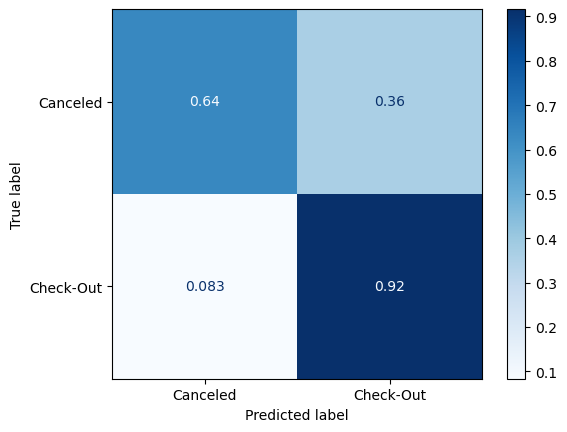

In [ ]:
y_pred = rf_classifier.predict(X_test_numeric)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

## Permutation Importances

***SKIPPING - NOT USED IN FINAL EVALUATION***

In [ ]:
# # ## Using Pipeline Model to calculate permutation importances
# # result = permutation_importance(model_pipeline[-1],
# #                                 X_test, 
# #                                 y_test,
# #                                 n_jobs=-1)#,
# #                                 # scoring = 'f1')


# ## Using SMOTENC Model to calculate permutation importances
# result = permutation_importance(smotenc_model,
#                                 X_test_transformed, 
#                                 y_test,
#                                 n_jobs=-1)#,
#                                 # scoring = 'f1')


# # Extract importances and standard deviations
# perm_importances = result.importances_mean
# perm_importances_std = result.importances_std

# # Create a DataFrame for easy plotting
# importance_df = pd.DataFrame({
#     'Feature': X_test_transformed.columns,
#     'Importance': perm_importances,
#     'Importance_std': perm_importances_std
# }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# # Plot the feature importances
# sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

KeyboardInterrupt: 